In [17]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import tensorflow as tf
import pandas as pd
from Evaluator import ModelEvaluator

In [18]:
data=pd.read_csv('datasets/malicious_data_generated.csv')
npdata=data.to_numpy()
malData=np.copy(npdata)
print(type(malData[1,:]))
print(malData[:1].shape)

<class 'numpy.ndarray'>
(1, 10)


In [19]:
class MalwareEnv():
    def __init__(self):
        # Actions we can take, decrease, increse, none
        self.action_space = Discrete(10)
        # max-min array
        self.observation_space = Box(low=-100,high=100,shape=(10,))
        
        # Set start 
        self.state = np.asarray(malData[random.randint(0,499),:])
        
        # Set time 
        self.length = 100
        
        self.evaluator=ModelEvaluator()
        
    def step(self, action):
        # Apply action for each state
        
        if(action<10):
           if(action==0):
               self.state[0]=round(random.uniform(-0.290698,133.441860),6)
           elif(action==1):
                self.state[1]=round(random.uniform(0,1184),6)
           elif(action==2):
                self.state[2]=round(random.uniform(-0.666667,10.666667),6)
           elif(action==3):
                self.state[3]=round(random.uniform(-0.312383,109.259173),6)
           elif(action==4):
                self.state[4]=round(random.uniform(0,30),6)
           elif(action==5):
                self.state[5]=round(random.uniform(-0.322,127.488889),6)
           elif(action==6):
                self.state[6]=round(random.uniform(-0.282353,147.976471),6)
           elif(action==7):
                self.state[7]=round(random.uniform(-0.164688,715.616633),6)
           elif(action==8):
                self.state[8]=round(random.uniform(-0.324081,106.407677),6)
           else:
                self.state[9]=round(random.uniform(-0.750000,227.5),6)  
        
        self.length -= 1 
            
        
        # Calculate reward in ranges
        
        value=self.state.tolist()
        result=self.evaluator.test(value)
        result=np.array2string(result)
        
        if(result=="['benign']"):
                 reward=+1
                 
        else:
                 reward=-1
                 
        
        # Check if is done
        if self.length <= 0:
            
            done = True
        else:
            done = False
        
        
        info = {}
        
        # Return step information
        return self.state, reward, done, info

    def render(self):
        pass
    
    def reset(self):
        # Reset 
        self.state = malData[random.randint(0,498),:]
        # Reset time
        self.length = 100 
        return self.state

In [20]:
env = MalwareEnv()

In [21]:
env.observation_space.sample()

array([  5.0470552, -72.46954  , -72.15255  , -54.934284 ,  -4.011825 ,
        69.37401  ,  81.907394 , -92.91169  ,  15.733333 , -83.5216   ],
      dtype=float32)

In [22]:
with tf.device('/gpu:0'):
    episodes = 2
    for episode in range(1, episodes+1):
        state = env.reset()
        done = False
        score = 0 
    
        while not done:
            env.render()
            action = env.action_space.sample()
            n_state, reward, done, info = env.step(action)
            score+=reward
        print('Episode:{} Score:{}'.format(episode, score))

Episode:1 Score:96
Episode:2 Score:100


In [23]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow

In [24]:
states = env.observation_space.shape
actions = env.action_space.n

In [25]:
actions

10

In [26]:
states

(10,)

In [27]:
def build_model(states, actions):
    with tf.device('/gpu:0'):
        model = tensorflow.keras.models.Sequential()   
        model.add(tensorflow.keras.layers.Dense(24, activation='relu', input_shape=(1,10)))
        model.add(tensorflow.keras.layers.Dense(24, activation='relu'))
        model.add(tensorflow.keras.layers.Dense(10, activation='linear'))
        model.add(Flatten())

        return model

In [28]:

#with tf.device('/gpu:0'):
model = build_model(states, actions)

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1, 24)             264       
_________________________________________________________________
dense_4 (Dense)              (None, 1, 24)             600       
_________________________________________________________________
dense_5 (Dense)              (None, 1, 10)             250       
_________________________________________________________________
flatten_1 (Flatten)          (None, 10)                0         
Total params: 1,114
Trainable params: 1,114
Non-trainable params: 0
_________________________________________________________________


In [30]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory


In [31]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=100, target_model_update=1e-2)
    return dqn

In [47]:

dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
history=dqn.fit(env, nb_steps=10000, visualize=False, verbose=1,log_interval=2000)

Training for 10000 steps ...
Interval 1 (0 steps performed)
2000/2000 [==============================] - 54s 27ms/step - reward: 0.6010
20 episodes - episode_reward: 60.100 [-82.000, 100.000] - loss: 136.480 - mae: 68.024 - mean_q: 144.821

Interval 2 (2000 steps performed)
1066/2000 [==============>...............] - ETA: 25s - reward: 0.6060done, took 82.667 seconds


In [ ]:
scores = dqn.test(env, nb_episodes=10, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 10 episodes ...
Episode 1: reward: 100.000, steps: 100
Episode 2: reward: 100.000, steps: 100
Episode 3: reward: 92.000, steps: 100
Episode 4: reward: 100.000, steps: 100
Episode 5: reward: 100.000, steps: 100
Episode 6: reward: 100.000, steps: 100
Episode 7: reward: 80.000, steps: 100
Episode 8: reward: 100.000, steps: 100
Episode 9: reward: 100.000, steps: 100
Episode 10: reward: 100.000, steps: 100
97.2


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
print(history.history.keys())

dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])


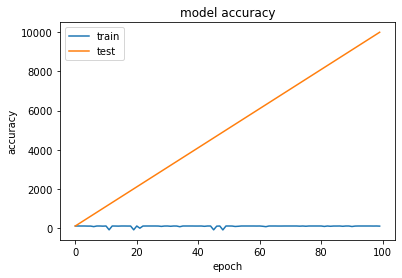

In [ ]:
plt.plot(history.history['episode_reward'])
plt.plot(history.history['nb_steps'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()